In [39]:
import nibabel as nib
import numpy as np
import pydicom
from tkinter import filedialog
import tkinter as tk
import glob
from tqdm import tqdm
import torch
import h5py
import matplotlib.pyplot as plt
import os
import copy
import csv

In [4]:
#check if cuda is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [31]:
def tkinter_gui(flavour_text):
    """
    This function creates a Tkinter window for browsing directories and returns the selected directory path.

    Parameters
    ----------
    flavour_text : str
        A string to display in the Tkinter window.

    Returns
    -------
    selected_directory : str
        The selected directory path.

    Examples
    --------
    >>> selected_directory = tkinter_gui("Select a directory")
    """
    
    def browse_directory():
        directory_path = filedialog.askdirectory()
        if directory_path:
            nonlocal selected_directory
            selected_directory = directory_path
            root.destroy()  # Close the Tkinter window

    # Create the main window
    root = tk.Tk()
    root.title("Directory Browser")

    # Create a label and button to display selected directory and browse
    directory_label = tk.Label(root, text=flavour_text, padx=10, pady=10)
    directory_label.pack()
    browse_button = tk.Button(root, text="Browse", command=browse_directory)
    browse_button.pack()

    # Run the application
    selected_directory = None  # Initialize selected_directory variable
    root.mainloop()
    if selected_directory:
        return selected_directory   
    else:
        raise ValueError("No directory selected")
    



def normalization_container(data, dims_inp):
    """
    This function z-score normalizes the data in the input array.

    Parameters
    ----------
    data : numpy.ndarray
        The input data array to be normalized.
    dims_inp : tuple/list
        The dimensions of the input data array.

    Returns
    -------
    image_container : numpy.ndarray
        The normalized data array.

    Examples
    --------
    >>> data_normalized = normalization_container(data, dims_inp)
    """

    print("Normalizing data...")

    # Create an empty array to store the normalized data
    image_container = np.empty((0, dims_inp[1], dims_inp[2]))

    # Iterate over the data and normalize each slice
    for image in tqdm(data):
        for slice in image:
            ninetynine_max = np.percentile(slice, 99)
            one_min = np.percentile(slice, 1)
            slice = np.clip(slice, one_min, ninetynine_max)

            curr_mean = np.mean(slice)
            curr_std = np.std(slice)
            slice = (slice - curr_mean) / curr_std
            slice = np.array([slice])
            image_container = np.concatenate((image_container, slice), axis=0, dtype=np.float32)
    
    return image_container


def normalization_container_torch_cuda(data, counter, dirname, dims_inp):
    """
    This function z-score normalizes the data in the input array and saves the normalized data as PyTorch tensors.

    Parameters
    ----------
    data : numpy.ndarray
        The input data array to be normalized.
    counter : int
        The counter to be used in the file name.
    dirname : str
        The directory path to save the normalized data.
    dims_inp : tuple/list
        The dimensions of the input data array.

    Returns
    -------
    None

    Examples
    --------
    >>> normalization_container_torch_cuda(data, counter, dirname, dims_inp)
    """

    # Create a directory to save the normalized data
    if os.path.exists(dirname + "\\normalized_pt_tensors") == False:
        os.mkdir(dirname + "\\normalized_pt_tensors")
    else:
        print("Save directory already exists, skipping creation...")

    # Create an empty tensor to store the normalized data
    image_container = (torch.from_numpy(np.empty((0, dims_inp[1], dims_inp[2])))).to(device)

    # Iterate over the data and normalize each slice
    for image in tqdm(data):
        for slice_ in image:
            ninetynine_max = np.percentile(slice_, 99)
            one_min = np.percentile(slice_, 1)
            slice_ = np.clip(slice_, one_min, ninetynine_max)

            curr_mean = np.mean(slice_)
            curr_std = np.std(slice_)
            slice_ = (slice_ - curr_mean) / curr_std
            slice_ = np.clip(slice_, -1, 1)
            slice_ = np.array([slice_], dtype=np.float32)

            # Convert the numpy array to a PyTorch tensor and move it to the GPU
            slice_ = torch.from_numpy(slice_).to(device)
            image_container = torch.cat((image_container, slice_), 0)
    
    # Save the normalized data
    print("Saving normalized data...")      
    torch.save(image_container, dirname + "\\normalized_pt_tensors\\" + 'data_normalized_' + str(counter) + '.pt')

    return


def normalization_container_single_torch_cuda(data, counter, dirname, dims_inp):
    """
    This function z-score normalizes the data in the input array and saves the normalized data as PyTorch tensors.
    Functionality is identical to normalization_container_torch_cuda, but is used for single-slice data.

    Parameters
    ----------
    data : numpy.ndarray
        The input data array to be normalized.
    counter : int
        The counter to be used in the file name.
    dirname : str
        The directory path to save the normalized data.
    dims_inp : tuple/list
        The dimensions of the input data array.

    Returns
    -------
    None

    Examples
    --------
    >>> normalization_container_single_torch_cuda(data, counter, dirname, dims_inp)
    """

    # Create a directory to save the normalized data
    if os.path.exists(dirname + "\\normalized_pt_tensors") == False:
        os.mkdir(dirname + "\\normalized_pt_tensors")
    else:
        print("Save directory already exists, skipping creation...")

    # Create an empty tensor to store the normalized data
    image_container = (torch.from_numpy(np.empty((0, dims_inp[0], dims_inp[1])))).to(device)

    # Normalize the data
    for slice_ in data:
        ninetynine_max = np.percentile(slice_, 99)
        one_min = np.percentile(slice_, 1)
        slice_ = np.clip(slice_, one_min, ninetynine_max)

        curr_mean = np.mean(slice_)
        curr_std = np.std(slice_)
        slice_ = (slice_ - curr_mean) / curr_std
        slice_ = np.clip(slice_, -1, 1)
        slice_ = np.array([slice_], dtype=np.float32)

         # Convert the numpy array to a PyTorch tensor and move it to the GPU
        slice_ = torch.from_numpy(slice_).to(device)
        image_container = torch.cat((image_container, slice_), 0)
    
    # Save the normalized data    
    torch.save(image_container, dirname + "\\normalized_pt_tensors\\" + 'data_normalized_' + str(counter) + '.pt')

    return

In [10]:
# Select the directory containing the data to be normalized
input_data_dir = tkinter_gui("Select the directory containing the data to be normalized")
input_files_dcm = glob.glob(input_data_dir + "/*.dcm", recursive=True)
input_files_nii = glob.glob(input_data_dir + "/*.nii", recursive=True)
input_files_nii_gz = glob.glob(input_data_dir + "/*.nii.gz", recursive=True)
input_files_h5 = glob.glob(input_data_dir + "/*.h5", recursive=True)

# Check the filetype of the input data
if len(input_files_dcm) > 0:
    mode = "dcm"
    print(len(input_files_dcm) , "DICOM files detected")
elif len(input_files_nii) > 0 or len(input_files_nii_gz) > 0:
    mode = "nii"
    print(len(input_files_nii) , "Nifti files detected")
elif len(input_files_h5) > 0:
    mode = "h5"
    print(len(input_files_h5) , "HDF5 files detected")
else:
    raise ValueError("No valid files detected in the directory")

# Set up initial variables
data_batched = []
temp_cont = []
desired_batchsize = 20

48 DICOM files detected


In [36]:
# Load the data and normalize it depending on the filetype

if mode == "nii":
    #load nifti files
    input_files = input_files_nii
    filenames = [f.split('\\')[-1] for f in input_files]

    counter = 0
    for file in input_files:
        if counter == desired_batchsize:
            data_batched.append(temp_cont)
            temp_cont = []
            counter = 0
        temp_cont.append(file)
        counter += 1

    counter = 0

    #load nifti files and normalize
    for batch in tqdm(data_batched):
        all_imgs = []
        dataloc_container = []

        for file in (batch):
            img = nib.load(file)
            data = np.fliplr(np.transpose(img.get_fdata(), (2, 1, 0))) 
            dims = data.shape
            print("Data shape: ", dims)
            all_imgs.append(data)

        #print("Slice dimensions: ", dims)

        target = dims[0]
        print("Target: ", target)
        padded_imgs = []

        #add empty slices to each image to make them all the same size - not necessary but seems to assist training
        for element in (all_imgs):
            while element.shape[0] < target:
                element = np.concatenate((element, np.zeros((1, element.shape[1], element.shape[2]))), axis=0)
            while element.shape[0] > target:
                element = np.delete(element, -1, axis=0)
            assert element.shape[0] == target
            assert element.shape[1] == dims[1], "Element shape: " + str(element.shape[1]) + " Dims: " + str(dims[1]) + "do not match"
            assert element.shape[2] == dims[2], "Element shape: " + str(element.shape[2]) + " Dims: " + str(dims[2]) + "do not match"
            if element.shape == dims:
                padded_imgs.append(element)

        print("Number of images: ", len(padded_imgs))
        print("Image dimensions: ", padded_imgs[0].shape)

        #modify the data to be in the correct format for the model
        del all_imgs
        padded_imgs = np.array(padded_imgs, copy=False, dtype=np.float32)
        assert padded_imgs.shape == (len(batch), dims[0], dims[1], dims[2])

        #normalize the data and send to GPU tensor
        normalization_container_torch_cuda(padded_imgs, counter, input_data_dir, dims)

        del padded_imgs
        torch.cuda.empty_cache()
        counter += 1

if mode == "dcm":
    input_files = input_files_dcm
    
    temp_inputfiles = []
    for file in input_files:
        dcm = pydicom.read_file(file)
        if "t1" in (dcm.SeriesDescription).lower():
            temp_inputfiles.append(file)
    input_files = temp_inputfiles

    print("Number of T1w DICOM files: ", len(input_files), "\n")
    data_batched = []
    temp_cont = []

    #load data
    counter = 0
    for file in input_files:
        if counter == desired_batchsize:
            data_batched.append(temp_cont)
            temp_cont = []
            counter = 0
        temp_cont.append(file)
        counter += 1

    for i, element in enumerate(data_batched):
        if len(element) != 20:
            data_batched.pop(i)

    dataloc_container = np.array(copy.deepcopy(data_batched)).flatten()
    print(len(dataloc_container), "images loaded \n")
    
    counter = 0
    #load dicom files and normalize
    print("Normalizing and saving data...")
    for batch in tqdm(data_batched):
        all_imgs = []

        for file in (batch):
            img = pydicom.read_file(file)
            data = img.pixel_array
            dims = data.shape
            all_imgs.append(data)
        
        #normalize the data and send to GPU tensor
        all_imgs = np.array(all_imgs, copy=False, dtype=np.float32)
        normalization_container_single_torch_cuda(all_imgs, counter, input_data_dir, dims)

        del all_imgs
        torch.cuda.empty_cache()
        counter += 1


if mode == "h5":
    #get all h5 files in directory and subdirectories
    input_files = input_files_h5
    input_files = [file for file in input_files if 'T1' in file]

    #get filenames and load data
    filenames = [f.split('\\')[-1] for f in input_files]

    counter = 0
    for file in input_files:
        if counter == desired_batchsize:
            data_batched.append(temp_cont)
            temp_cont = []
            counter = 0
        temp_cont.append(file)
        counter += 1

    counter = 0

    #load h5 files and normalize
    for batch in tqdm(data_batched):
        all_imgs = []

        for file in (batch):
            temp_img_cont = []
            try:
                f = h5py.File(file, 'r')
                pixel_data = f["reconstruction_rss"]
                for slice in pixel_data:
                    temp_img_cont.append(slice)
                data = np.array(temp_img_cont, copy=False, dtype=np.float32)
                dims = data.shape
                all_imgs.append(data)
            except:
                print("Error in file: ", file)
                break
            
            #normalize the data and send to GPU tensor
            all_imgs = np.array(all_imgs, copy=False, dtype=np.float32)
            normalization_container_torch_cuda(all_imgs, counter, input_data_dir, dims)

            del all_imgs
            torch.cuda.empty_cache()
            counter += 1


Number of T1w DICOM files:  32 

20 images loaded 

Normalizing and saving data...


  0%|          | 0/1 [00:00<?, ?it/s]

Save directory already exists, skipping creation...
Saving normalized data...


100%|██████████| 1/1 [00:00<00:00,  3.77it/s]


In [40]:
#save the filenames to a txt file
#with open(input_data_dir + "\\filenames.txt", 'w') as f:
 #   for item in filenames:
  #      f.write("%s\n" % item)

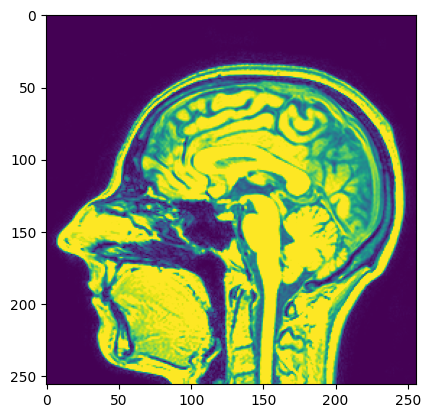

In [ ]:
#visualize the data for review
pt_files = glob.glob(input_data_dir + '\\normalized_pt_tensors\\*pt')

for files in pt_files:
    data = torch.load(files)
    data_numpy = data.cpu().numpy()

    for i in range (len(data_numpy)):
        if i == 75:
            plt.imshow(data_numpy[i])
            plt.title("Slice: " + str(i))
            plt.colorbar()
            plt.show()

    break